In [ ]:
#@title Setup Repository
PROJECT_DIR = 'StyleRes'
!pip uninstall -y torch torchvision torchtext torchdata torchaudio
!pip install torch==1.11.0+cu102 torchvision==0.12.0+cu102 --extra-index-url https://download.pytorch.org/whl/cu102
!pip install ninja
from PIL import Image
import torch
import os
os.chdir('/content')
!git clone https://github.com/hamzapehlivan/StyleRes.git $PROJECT_DIR


In [ ]:
if not torch.cuda.is_available():
  print("Running model on CPU. If you need GPU suuport, change runtime type of Colab Notebook ")

In [2]:
#@title Download Model
# Downloader class is 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

download_with_pydrive = True #@param {type:"boolean"}
os.chdir(f'/content/{PROJECT_DIR}')

class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive
        current_directory = os.getcwd()
        self.save_dir = os.path.join(current_directory, "checkpoints")
        os.makedirs(self.save_dir, exist_ok=True)
        if self.use_pydrive:
            self.authenticate()

    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)

    def download_file(self, file_id, file_name):
        file_dst = f'{self.save_dir}/{file_name}'
        if os.path.exists(file_dst):
            print(f'{file_name} already exists!')
            return
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)

MODEL_PATHS = {
    "styleres_ffhq": {"id": "1SXNe_txGQaGQg3AthSdwlBAlDPjlzFet", "name": "styleres_ffhq.zip"},
}
#1cUv_reLE6k3604or78EranS7XzuVMWeO

path = MODEL_PATHS['styleres_ffhq']
downloader.download_file(file_id=path["id"], file_name=path["name"])
os.chdir('checkpoints')
!unzip styleres_ffhq.zip
!rm -rf styleres_ffhq.zip
os.chdir('..')
print("Downloaded pretrained models")

Archive:  styleres_ffhq.zip
  inflating: styleres_ffhq.pth       
Downloaded pretrained models


In [4]:
#@title Load StyleRes
from inference import initialize_styleres
from datasets.process_image import ImageProcessor

device = 'cuda' if torch.cuda.is_available() else 'cpu'
styleres = initialize_styleres('checkpoints/styleres_ffhq.pth', device)
image_processor = ImageProcessor()
if device == 'cuda':
  print("StyleGAN compiles custom C++ codes, therefore, the first run might be slow.")

Model succesfully loaded


In [5]:
#@title Choose Image
selected_image = '116.jpg' #@param ["116.jpg", "11654.jpg", "1219.jpg", "3897.jpg", "6898.jpg", "756.jpg"]
input_image = Image.open(f"samples/inference_samples/{selected_image}")

In [10]:
#@title Choose Editing 
import ipywidgets as widgets
from IPython.display import display

from utils import AppUtils
utils = AppUtils()

edit_methods = ['InterfaceGAN', 'GANspace', 'StyleClip']
method = edit_methods[-1]
method_dropdown = widgets.Dropdown(
    options=edit_methods,
    value = method,
    description='Edit Method',
)

edits = dict( InterfaceGAN= ['Smile', 'Age', 'Pose'],
              GANspace=['Lipstick', 'Trimmed Beard', 'Eye Openness'], 
              StyleClip=['Purple Hair', 'Curly Hair', 'Trump'])

edits_dropdown = widgets.Dropdown(
    options=edits[method],
    value=edits[method][0],
    description='Edit:',
)

factor_slider = widgets.FloatSlider(
    value=0.1,
    min=0,
    max=0.2,
    step=0.01,
    description='Factor:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal'
)

def on_change_method(change):
  if change['type'] == 'change' and change['name'] == 'value':
    method = change['new']
    edits_dropdown.options = edits[method]
    edits_dropdown.value = edits[method][0]
    minimum, maximum, step= utils.get_range(method)
    print(method)
    factor_slider.min = minimum
    factor_slider.max = maximum
    factor_slider.step = step
    if method == 'InterfaceGAN':
      factor_slider.value = 2.5
    elif method == 'StyleClip':
      factor_slider.value = 0.1
    else:
      factor_slider.value = 10.0


method_dropdown.observe(on_change_method)
print("IMPORTANT: When you change the edit method, available methods will also be changed automatically. Because we are on a Colab Server, this might take 1-2 seconds")
display(method_dropdown)
display(edits_dropdown)
display(factor_slider)

Dropdown(description='Edit Method', index=2, options=('InterfaceGAN', 'GANspace', 'StyleClip'), value='StyleCl…

Dropdown(description='Edit:', options=('Purple Hair', 'Curly Hair', 'Trump'), value='Purple Hair')

FloatSlider(value=0.1, continuous_update=False, description='Factor:', max=0.2, step=0.01)

InterfaceGAN
GANspace
StyleClip


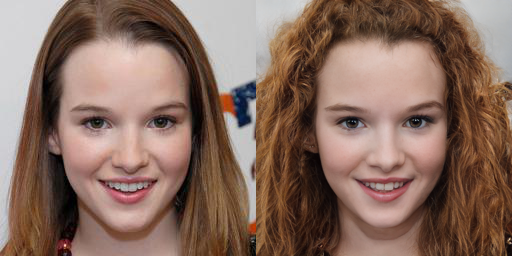

In [13]:
#@title Edit Image

def process_image(image, method,  edit, factor):
    cfg = utils.args_to_cfg(method, edit, factor)
    image = image_processor.preprocess_image(image, is_batch=False)
    image = styleres.edit_images(image, cfg)
    image = image_processor.postprocess_image(image.detach().cpu().numpy(), is_batch=False).resize((256,256))
    return image

edited_image = process_image(input_image, method_dropdown.value, edits_dropdown.value, factor_slider.value)
total_width = input_image.width + edited_image.width
max_height = max(input_image.height, edited_image.height)
result_image = Image.new('RGB', (total_width, max_height))
result_image.paste(input_image, (0,0))
result_image.paste(edited_image, (input_image.width,0))
display(result_image)